# RELISON: A framework for REcommending LInks in SOcial Networks

RELISON is a framework for experimentation on the link recommendation task in social networks, which aims to identify those people in the network with whom a user might be interested to connect, interact or befriend. RELISON provides tools for executing and evaluating contact recommendation approaches, considering not only their accuracy, but also aspects like their novelty, diversity and the effects that such recommendations have on global properties of the networks (as changes in the structural properties or in the characteristics of the information arriving to the users). In order to measure these effects, RELISON also provides functionality for a) analyzing the structural properties of social networks, b) detecting clusters of users (communities) and c) simulating the diffusion of information in a social network. These functionalities can be used regardless of whether recommendations have been provided to the users.

This notebook provides a simple tutorial on how to use the standard functionalities and command line programs of the RELISON framework. After the tutorial is finished, you shall learn how to:

1. Generate random networks with different properties.
2. Analyze the properties of a network or graph.
3. Execute link recommendations over that network.
4. Find communities of tightly connected users.
5. Simulate information diffusion over the networks.

## Installation

As a first step, we need to install and configure the RELISON framework so we can work with it. In this case, we download it from the Git repository, we install the different Maven packages, and we build the definitive executable JAR, so we can execute the different command line programs provided by the framework.


**Note:** If you have reached here from the provided Docker container in the repository, this step is unnecessary.

In [ ]:
!mkdir RELISON
!git clone https://github.com/ir-uam/RELISON.git RELISON/
%cd RELISON
!mvn install
%cd RELISON-examples
!mvn clean compile assembly:single
!mv ./target/RELISON-examples-1.0.0-jar-with-dependencies.jar ../RELISON.jar
%cd ..
%cd ..

Once we have installed our repository, we can configure the variables we are going to need to execute the tutorial. need to define the following variables:
- **JAR file:** The actual location of the JAR file. If it has been downloaded through the previous commands, it should be on `./RELISON/RELISON.jar`. If you are using the Docker image, it is on `/tmp/RELISON/RELISON.jar`.
- **Training graph:** The example training graph
- **Test graph:** The example test graph.

In [1]:
jar_file = './RELISON/RELISON.jar'
train_graph = './RELISON/data/train.txt'
test_graph = './RELISON/data/test.txt'

In [34]:
!pip3 install pandas
!pip3 install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 11.3MB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 931kB 51.6MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 57.2MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 63.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


We show first how the graph files are defined. Each row of the file contains a different edge. An edge has the following information:
- Origin node
- Destination node
- Weight of the node
- Type of the node (optional, not in this example)
These fields are tab separated. We load, as an example, the training graph using Pandas.

In [20]:
import pandas as pd
import sys, os

In [7]:
pd.read_csv(train_graph, delimiter='\t', names=["origin","dest","weight"])

,origin,dest,weight
0,0,1,1.0
1,0,2,1.0
2,0,3,2.0
3,0,4,1.0
4,0,5,1.0
...,...,...,...
170420,542,4085,1.0
170421,9497,4,1.0
170422,9497,42,1.0
170423,9497,6,1.0


## Step 1: Analyzing the structural properties of a network

Once we have a network, the first thing we might be interested on doing is to study its structural properties. In order to get such properties, we use the `sna` program provided by the library. If we execute it without further information, we might observe the required and optional arguments of the program and a description.

In [8]:
!java -jar $jar_file sna

sna
ERROR: Invalid arguments.
Usage:
	Graph file: a file containing the graph to analyze.
	Multigraph: true if the network allows multiple edges, false otherwise.
	Directed: true if the network is directed, false otherwise.
	Weighted: true if the network is weighted, false otherwise.
	Selfloops: true if the network allows self-loops, false otherwise.
	Metrics: a YAML file containing the metrics to compute.
	Output: the directory in which to store the metrics.

	Optional parameters:
		-communities commFile1,...,commFileN: a comma separated list of files containing communities.
		--distances: include if we want to precompute distance metrics (recommended if any is used)


As we can observe, we need to provide information about the network to analyze, as well as a YAML file containing the metrics to compute and a dictionary to store the metrics. If we need to use communities, we can also provide files (we'll explore that later). Also, if we compute distance-based metrics, we can pre-compute them.

In the case of just analyzing the properties of a network, using the `--distances` flag is recommended. Otherwise, it might be necessary to compute distances for each of the metrics.

As example metrics, in this example, we are using the provided YAML file in the repository, which explores three metrics:
- Clustering coefficient
- Eccentricity
- Embeddedness

We print below the YAML file for executing these three metrics.

```yaml
metrics:
  Clustering coefficient:
    type: graph
    params:
      uSel:
        type: orientation
        values: IN
      vSel:
        type: orientation
        values: OUT
  Eccentricity:
    type: vertex
  Embeddedness:
    type: edge
    params:
      uSel:
        type: orientation
        values: OUT
      vSel:
        type: orientation
        values: IN 
```

So, in the following commands, we define the outgoing folder, and we execute our program. We are working with a simple, directed and weighted graph. We shall avoid self-loops, so:

In [9]:
!mkdir ./metrics-res

In [22]:
output_dir = "./metrics-res/"
multigraph = "false"
directed = "true"
weighted = "true"
self_loops = "false"
metrics_yaml = "./RELISON/Example\\ configuration\\ files/metrics-example.yml"

!java -Xss10m -jar $jar_file sna $train_graph $multigraph $directed $weighted $self_loops $metrics_yaml $output_dir --distances

Once the program has been executed, we can obtain the results from the output folder. In the example, we have studied vertex, edge and graph metrics, so we shall go throughout them.

### Graph metrics
Graph metrics are global to the whole graph. That means that a single numeric value is enough to represent it. The values of graph metrics are stored in the `global.txt` file in the output directory. Each line shows the name and value of the corresponding metric. In the case of individual vertex and edge metrics, this file contains the average value:

In [26]:
pd.read_csv(os.path.join(output_dir, "global.txt"), delimiter='\t', index_col=0)

,value
metric,
Average Embeddedness_OUT_IN,0.024317
Average Eccentricity,6.673384
Clustering coefficient_IN_OUT,0.056206


### Vertex metrics
Vertex metrics are properties related to a single node in the graph. As its distribution might be interesting, we store the individual values in the `vertex` directory of the output folder. For each metric, we store a different file. In this case, we only have the `Eccentricity` metric. Below, we show the nodes with a greater eccentricity (maximum finite distance from the node to the rest of them in the network)

In [29]:
eccentricity = pd.read_csv(os.path.join(os.path.join(output_dir, "vertex"), "Eccentricity.txt"), delimiter='\t', index_col=0)
eccentricity.sort_values(by="metric", ascending=False).head(10)

,metric
node,
9237,13.0
7897,13.0
7118,12.0
2413,12.0
8509,12.0
8208,12.0
7445,12.0
3196,12.0
7896,12.0


Considering that we have the individual data, it is simple for us to plot the distribution of the metric over the different nodes, in different formats.

#### Example 1: Density-like distribution
In this plot, the x axis shows the eccentricity values, and the y axis the number of nodes containing that value.

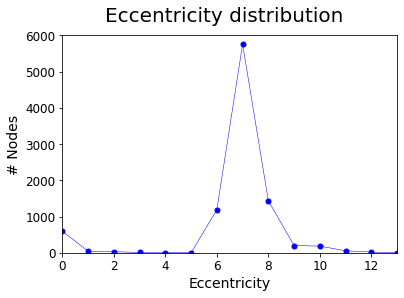

In [71]:
import matplotlib
import matplotlib.pyplot as plt


series = eccentricity['metric'].value_counts().sort_index()

x_values = [x for x in series.keys()]
x_values

y_values = [y for y in series]
y_values

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.suptitle('Eccentricity distribution', fontsize=20)
plt.plot(x_values, y_values, 'b', marker="o", markersize=5, linewidth=0.5)
plt.axis([0, 13, 0, 6000])
plt.xlabel('Eccentricity', fontsize=14)
plt.ylabel('# Nodes', fontsize=14)
plt.show()

#### Example 2: Cumulative like distribution
Here, we plot in the x axis the number of the node, and, in the y axis, the eccentricity value. For this, we sort the values from greater to smaller.

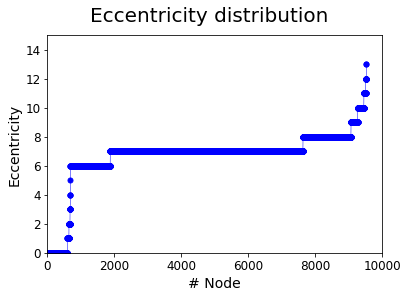

In [74]:
import matplotlib
import matplotlib.pyplot as plt

x_values = []
y_values = []

i = 0
for index, row in eccentricity.sort_values(by="metric", ascending=True).iterrows():
    x_values.append(i)
    i += 1
    y_values.append(row["metric"])

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.suptitle('Eccentricity distribution', fontsize=20)
plt.plot(x_values, y_values, 'b', marker="o", markersize=5, linewidth=0.5)
plt.axis([0, 10000, 0, 15])
plt.xlabel('# Node', fontsize=14)
plt.ylabel('Eccentricity', fontsize=14)
plt.show()